# Reconstruction - spherical model: $\dot{M}$
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
import copy

from astropy     import units, constants
from pomme.model import TensorModel, SphericalModel
from pomme.loss  import Loss, diff_loss
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from spherical import lines, velocities, frequencies, smodel, r_out, get_velocity, get_temperature, get_turbulence, get_boundary_condition
from spherical import smodel as smodel_truth

/STER/frederikd/pomme/docs/src/examples/spherical/spherical.py:46: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)


You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=7-6)
Please check the properties that were inferred:
    Frequency         8.066518060e+11  Hz
    Einstein A coeff  3.422000000e-05  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [2]:
obss = torch.load('obss.pt')

In [3]:
def get_abundance(model):
    """
    Get the CO abundance from the TensorModel.
    """
    # Extract parameters
    r      = torch.exp(model['log_r'])
    M_dot  = torch.exp(model['log_M_dot'])
    R_star = torch.exp(model['log_R_star'])

    v = get_velocity(model)

    rho  = M_dot / (4.0 * np.pi * r**2 * v)
    n_CO = (3.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
    n_CO[r<=R_star] = n_CO[n_CO<np.inf].max()

    return n_CO

In [9]:
smodel = SphericalModel(
    rs       = smodel_truth.rs,
    model_1D = TensorModel.load('model_truth.h5'),
    r_star   = smodel_truth.r_star,
)
smodel.get_abundance          = get_abundance
smodel.get_velocity           = get_velocity
smodel.get_temperature        = get_temperature
smodel.get_turbulence         = get_turbulence
smodel.get_boundary_condition = get_boundary_condition

del smodel.model_1D.vars['log_CO']

M_dot = (1.0e-5 * units.M_sun / units.yr).si.value

smodel.model_1D['log_M_dot'] = np.log(M_dot)

smodel.model_1D.free(['log_M_dot', 'log_v_in', 'log_v_inf', 'log_beta', 'log_T_in', 'log_epsilon'])

losses = Loss(['avg', 'rel'])

In [10]:
smodel.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_R_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_T_in                   Free          False    +7.824e+00     +7.824e+00     +7.824e+00
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_beta                   Free          False    -6.931e-01     -6.931e-01     -6.931e-01
  log_epsilon                Free          False    -5.108e-01     -5.108e-01     -5.108e-01
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_turbulence             Fixed         True     +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Free          False    +4.605e+00     +4.605e+00     +4.605e+00
  log_v_inf                  Free          False    +9.903e+00     +9.903e+00     +9.903e+00
  log_M_dot                  Free          False    +4.098e+01     +4.098e+01

In [11]:
imgs = smodel.image(lines, frequencies, r_max=r_out)

In [16]:
np.arange(1,11) * 1.0e-6

array([1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06,
       9.e-06, 1.e-05])

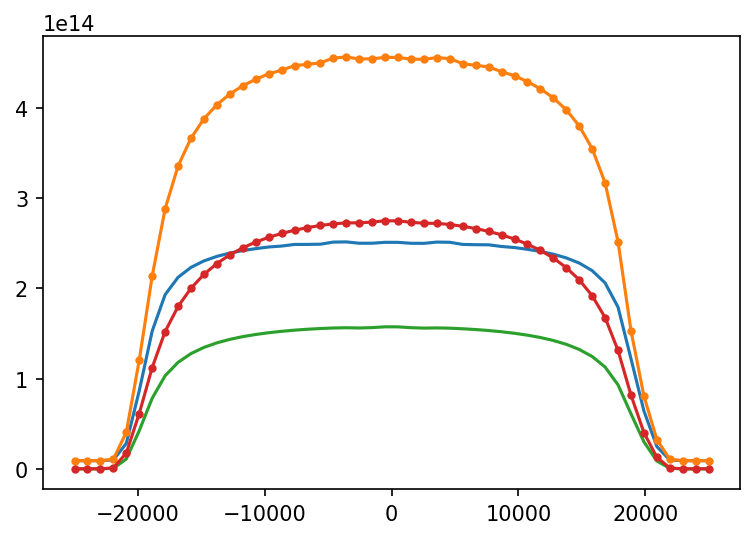

In [12]:
plt.figure(dpi=150)
for obs, img in zip(obss, imgs):
    plt.plot(velocities, obs.data)
    plt.plot(velocities, img.data, marker='.')

In [18]:
smodel.model_1D.free_parameters()

[tensor(7.8240, requires_grad=True),
 tensor(-0.6931, requires_grad=True),
 tensor(-0.5108, requires_grad=True),
 tensor(4.6052, requires_grad=True),
 tensor(9.9035, requires_grad=True),
 tensor(40.9846, requires_grad=True)]

In [13]:
from torch.optim import Adam
from tqdm        import tqdm

obss_avg = obss.mean(axis=1)
obss_rel = torch.einsum("ij, i -> ij", obss, 1.0 / obss.mean(axis=1))

# Get a mask for the elements outsife the star
outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        

def fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        smodel.model_1D['log_M_dot'],
        smodel.model_1D['log_v_in'],
        smodel.model_1D['log_v_inf'],
        smodel.model_1D['log_beta'],
        smodel.model_1D['log_T_in'],
        smodel.model_1D['log_epsilon'],
    ]

    abundance_evol = [smodel.get_abundance(smodel.model_1D).detach().clone()]
    
    optimizer = Adam(params, lr=lr)

    for _ in tqdm(range(N_epochs)):

        # Forward model
        imgs = smodel.image(lines, frequencies, r_max=r_out)

        imgs_avg= imgs.mean(axis=1)
        imgs_rel= torch.einsum("ij, i -> ij", imgs, 1.0 / imgs.mean(axis=1))

        # Compute the reproduction loss
        losses['avg'] = w_avg * torch.nn.functional.mse_loss(imgs_avg, obss_avg)
        losses['rel'] = w_rel * torch.nn.functional.mse_loss(imgs_rel, obss_rel)

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()

        abundance_evol.append(smodel.get_abundance(smodel.model_1D).detach().clone())

    return imgs, losses, abundance_evol

In [9]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=3, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

losses.renormalise_all()
losses.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:25<00:00,  8.55s/it]


In [10]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 10/10 [01:58<00:00, 11.88s/it]


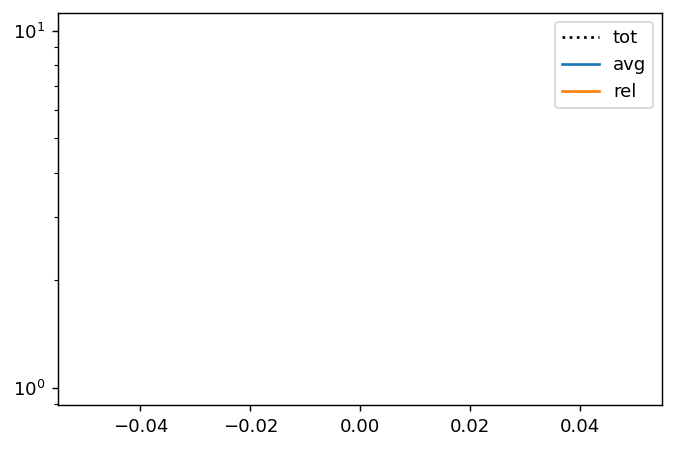

In [19]:
losses.plot()


In [12]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=500, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

 93%|█████████▎| 463/500 [1:21:18<06:51, 11.12s/it]

In [1]:
losses.plot()

NameError: name 'losses' is not defined

In [23]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=50, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 50/50 [09:34<00:00, 11.49s/it]


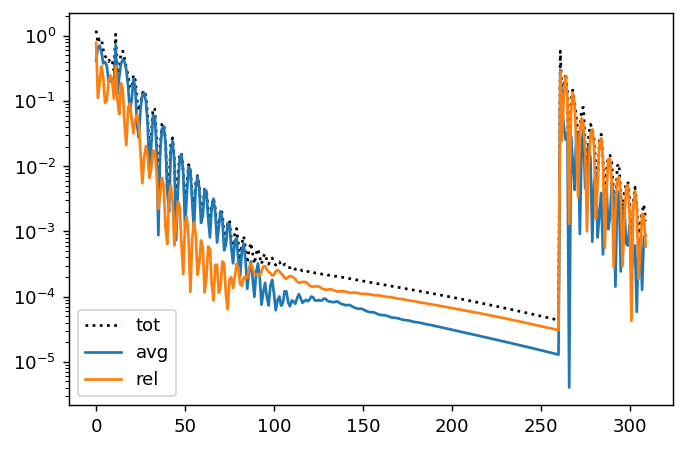

In [24]:
losses.plot()

In [ ]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=50, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 50/50 [09:32<00:00, 11.45s/it]


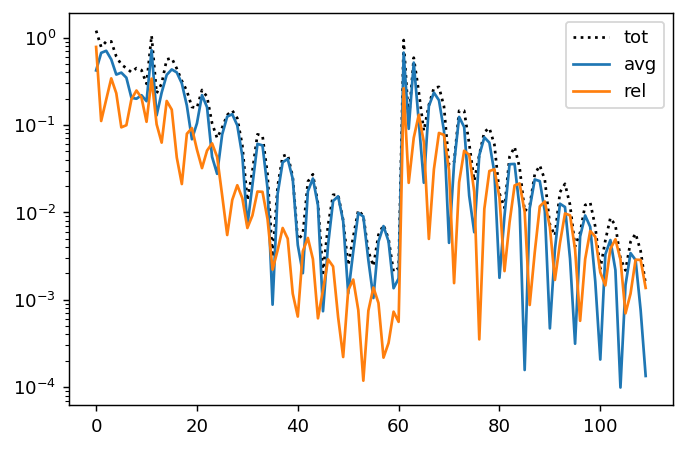

In [ ]:
losses.plot()

In [12]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 200/200 [06:26<00:00,  1.93s/it]


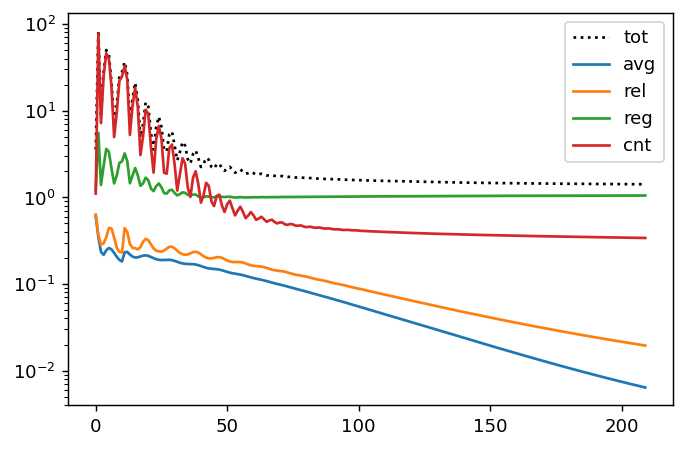

In [14]:
loss.plot()

In [15]:
imgs, loss, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=250, lr=1.0e-1, w_avg=1.0e+2, w_rel=1.0e+2, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 250/250 [07:53<00:00,  1.89s/it]


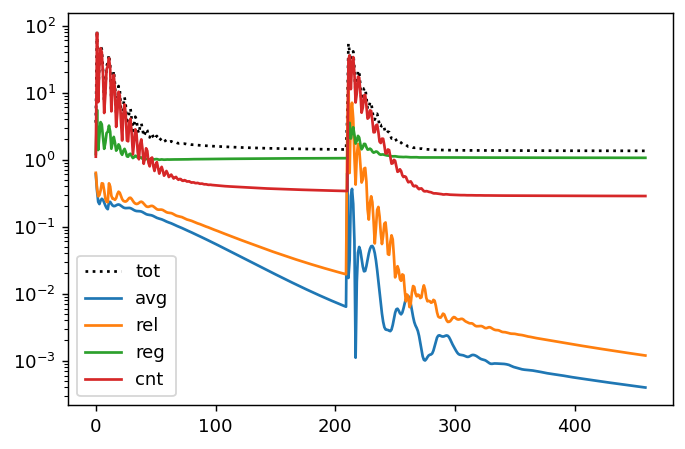

In [18]:
loss.plot()

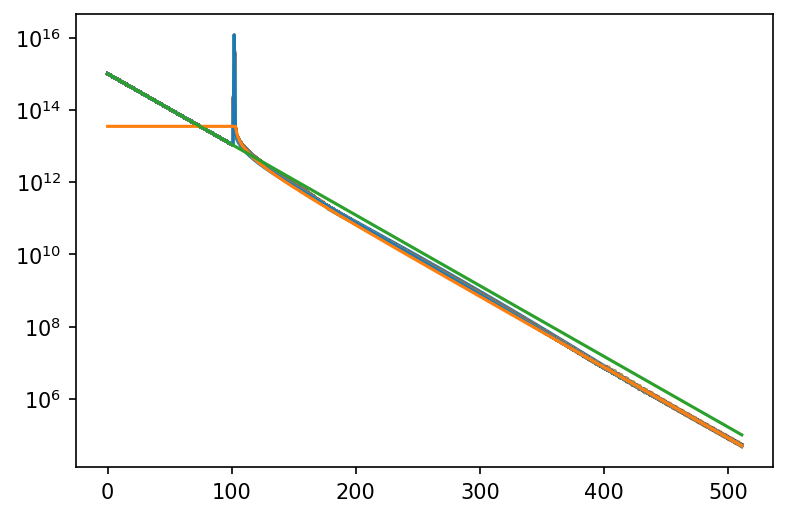

In [16]:
plt.figure(dpi=150)
for CO in a_evol[:]:
    plt.plot(CO)
plt.plot(torch.exp(smodel_truth.model_1D['log_CO']).data)
plt.plot(np.exp(log_n_CO_init))
plt.yscale('log')

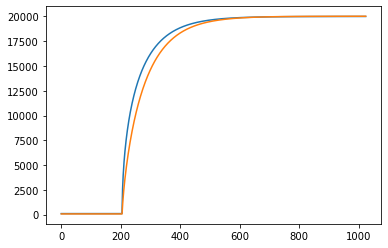

In [25]:
plt.plot(smodel_truth.get_velocity(smodel_truth.model_1D).data)
plt.plot(smodel      .get_velocity(smodel      .model_1D).data)

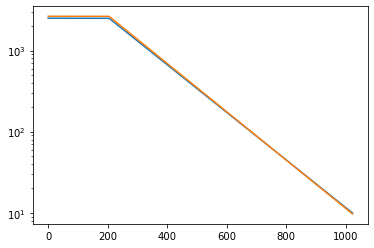

In [26]:
plt.plot(smodel_truth.get_temperature(smodel_truth.model_1D).data)
plt.plot(smodel      .get_temperature(smodel      .model_1D).data)

plt.yscale('log')

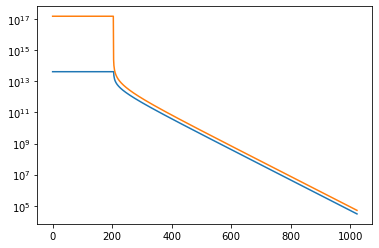

In [27]:
plt.plot(smodel_truth.get_abundance(smodel_truth.model_1D).data)
plt.plot(smodel      .get_abundance(smodel      .model_1D).data)
plt.yscale('log')

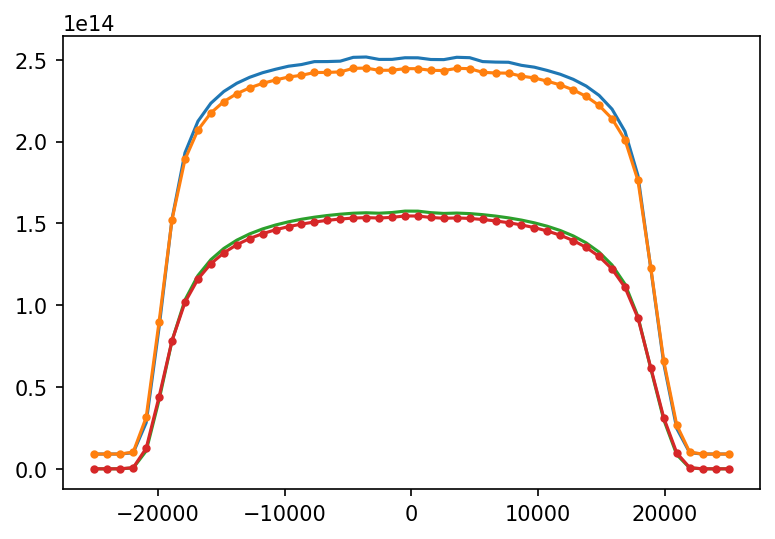

In [28]:
plt.figure(dpi=150)
for obs, img in zip(obss, imgs):
    plt.plot(velocities, obs.data)
    plt.plot(velocities, img.data, marker='.')

In [19]:
smodel.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_R_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_T_in                   Free          False    +7.780e+00     +7.780e+00     +7.780e+00
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_beta                   Free          False    -1.872e-01     -1.872e-01     -1.872e-01
  log_epsilon                Free          False    -5.230e-01     -5.230e-01     -5.230e-01
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_turbulence             Fixed         True     +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Free          False    +4.108e+00     +4.108e+00     +4.108e+00
  log_v_inf                  Free          False    +9.903e+00     +9.903e+00     +9.903e+00
  log_M_dot                  Free          False    +4.027e+01     +4.027e+01

In [22]:
torch.exp(smodel.model_1D['log_M_dot']).item() / (1.0 * units.M_sun / units.yr).si.value

4.895251532640947e-06